
| EDA dataframe      | Description |due|
| ----------- | ----------- |----------- |
| grape_train  | 캠벨얼리 가격/거래량 + 소비자 물가 지수 + 자동차용경유 + 날씨(4개-평균기온, 평균온량, 일강수량, 일교차) + 수출입(4개) + 재배면적 + 샤인머스켓 거래량 + 실업률_경제활동인구(2개-경제활동인구, 실업률) + 최저시급    |20190101 ~ 20201104|
| shinemuscat_train   |샤인마스캇  가격/거래량 + 소비자 물가 지수 + 자동차용경유 + 날씨(4개-평균기온, 평균온량, 일강수량, 일교차) + 수출입(4개) + 재배면적 + 블루베리 거래량 + 실업률_경제활동인구(2개-경제활동인구, 실업률) + 최저시급        |20190101 ~ 20201104|
| df      | grape_train + shinemuscat_train       | 20190101 ~ 2020928|

## Overview

## 주제:  농산물 품목별 가격 변동 예측 모델 구현

### 과제 선정 배경
코로나 사태가 지속되면서 온라인 시장이 급증하였다. 이에, 가격 변동 예측을 통해 필요한 상품을 필요한 주기에 적정가에 구매하여 구매 비용 및 폐기율 낮춰 생산량 조절


### 과제 주요 내용
- 농산물 가격은 추측이 어려운 경향이 있음. 기격에 영향을 미치는 요인으로 거래량, 기상, 가격,사회적인 이슈, 물가 상승률, 거래량, 유가, 생산량, 해외 수입량, 재배 면적 등 다양하지만, 그중 기상, 유가, 가격, 거래량 데이터를 이용. 해당 데이터들을 수집하여 전처리, 이상치 탐지, 정규화 등의 과정을 거친 뒤, 회귀 기법의 머신러닝 모델 및 딥러닝(LSTM)을 이용하여 모델을 학습하고 예측한다.
- 주기는 1,2,4주로 예측
- 이번 프로젝트에서는 토마토, 포도(캠벨얼리, 샤인마스캇) 총 3개의 작물에 대하여 가격 예측을 진행한다.
- 수요예측 -> 계획 생산 -> 좋은 품질을 연간 균일, 합리적인 가격

**preprocessing : 날씨데이터의 경우 품목별로 재배지역 80%내 재배지역 비율로 전처리**

**EDA : 농산물 품목별 계절 패턴이 뚜렷하고, 품목별로 다른 분포를 보임 -> 시계열 반영 모델 및 폼목별 모델 생성**<br>

**EDA & preprocessing : 주말(공휴일)의 경우 거래가 발생하지 않음 -> 모델 성능 저하 -> 전처리 필요(거래 전, 후의 가격 평균 대체)**

### 과제 목표
- 마켓컬리 '폐기율 0.1%' 도전, 고객의 성향이나 맥락, 상품 특성을 고려해 적절한 시기에 상품을 추천함으로써 고객이 원하는 상품을 빠르고 쉽게 찾아서 주문할 수 있도록 지원하기위해 가격 예측이 필요함
- 입력받은 일자의 1주 뒤의 가격을 예측하는 것을 목표로 한다. 예를 들어, 2021년 12월 31일의 데이터를 입력으로 한다면, 1월 7일, 1월 14일, 1월 28일의 가격을 수치형으로 예측한다. 모델의 성능 평가 지표는 농산물마다 가격 범위 차이가 큰 점을 반영하여 **``RMSE(Root-mean-square deviation)``** 를 사용하며, 해당 값이 0.2가 넘지 않게 하는 것을 목표로 한다.

### 데이터 수집
**train(학습용 데이터셋)**: ``20160101`` ~ ``20200928`` => EDA<br> 
**test(테스트 테이터셋)**: ``20200929 + 1week``~ ``20201104 +4week``


[V] 데이터 수집 기한 정하기 <br>
[ ] RMSE(평가지표) 예측 주기 정하기

### 캠벨얼리 외부데이터
소비자 물가 지수, 자동차용경유, 날씨(4개-평균기온, 평균온량, 일강수량, 일교차), 수출입(4개), 재배면적, 샤인머스켓(빅카인즈) 거래량(워드클라우드)   , 실업률_경제활동인구(2개-경제활동인구, 실업률), 최저시급


### 샤인마스캇 외부데이터
소비자 물가 지수, 자동차용경유, 날씨(4개-평균기온, 평균온량, 일강수량, 일교차), 수출입(4개), 재배면적, 블루베리 거래량(워드클라우드), 실업률_경제활동인구(2개-경제활동인구, 실업률), 최저시급


# 파생변수

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
# import tensorflow as tf
# import keras
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from tensorflow.keras import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, LSTM, Dropout
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

/var/folders/lm/z4n_2b8s6rj3_vv57sg789kc0000gn/T/ipykernel_93623/238796418.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# 0. 데이터셋(dataset)

**train** 20160101 ~ 20200928 <br> 
**test** 20200929 ~ 20201105

EDA와 기본 모델을 만들때 사용 <br>
train + test 합친 프레임(토마토, 포도) = df

In [2]:
# Macbook
# raw_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/raw/'
# processed_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/processed/'

In [2]:
# iMACA
raw_path = '/Users/cge/Documents/yeardream/project/kurly/products_price_predict/data/raw/'
processed_path = '/Users/cge/Documents/yeardream/project/kurly/products_price_predict/data/processed/'

In [3]:
# test 데이터 합치기
arr = os.listdir('/Users/cge/Documents/yeardream/project/kurly/data/public_data/test_files')
print(arr)
print()

filename_list = arr
filename_list_2020 = []    
for filename in filename_list :
    if '2020' in filename :
        filename_list_2020.append(filename)
        
path = '/Users//cge/Documents/yeardream/project/kurly/data/public_data/test_files/'
df_list = []
for filename in tqdm(filename_list_2020) :
    df = pd.read_csv(path + filename)
    df_list.append(df)
test = pd.concat(df_list, sort=False).reset_index(drop=True)

['test_2020-10-12.csv', 'test_2020-10-06.csv', 'test_2020-10-07.csv', 'test_2020-10-13.csv', 'test_2020-09-30.csv', 'test_2020-10-05.csv', 'test_2020-10-11.csv', 'test_2020-10-10.csv', 'test_2020-10-04.csv', 'test_2020-10-14.csv', 'test_2020-10-28.csv', 'test_2020-10-29.csv', 'test_2020-10-15.csv', 'test_2020-10-01.csv', 'test_2020-10-17.csv', 'test_2020-10-03.csv', 'test_2020-10-02.csv', 'test_2020-10-16.csv', 'test_2020-10-27.csv', 'test_2020-10-26.csv', 'test_2020-10-18.csv', 'test_2020-10-24.csv', 'test_2020-10-30.csv', 'test_2020-10-31.csv', 'test_2020-10-25.csv', 'test_2020-10-19.csv', 'test_2020-10-21.csv', 'test_2020-10-09.csv', 'test_2020-10-08.csv', 'test_2020-10-20.csv', 'test_2020-09-29.csv', 'test_2020-10-22.csv', 'test_2020-10-23.csv', '.ipynb_checkpoints', 'test_2020-11-04.csv', 'test_2020-11-05.csv', 'test_2020-11-02.csv', 'test_2020-11-03.csv', 'test_2020-11-01.csv']



100%|██████████| 38/38 [00:00<00:00, 522.48it/s]


In [4]:
arr2 = os.listdir(processed_path)
arr2

['shinemuscat_weather.csv',
 '.DS_Store',
 '캠벨얼리_전처리후.csv',
 '샤인머스켓_전처리후.csv',
 'shinemuscat.csv',
 'README.md',
 'grape.csv',
 'grape_실업률추가.csv',
 'grape_weather.csv',
 'shinemuscat_실업률추가.csv']

In [5]:
grape = pd.read_csv(processed_path+'grape_실업률추가.csv')
shinemuscat = pd.read_csv(processed_path+'shinemuscat_실업률추가.csv')

# train -> 2020년 9월 28일까지만 EDA 진행
grape_train = grape[:1733]
shinemuscat_train = shinemuscat[:1733]

df_train = pd.merge(grape_train, shinemuscat_train, on = ['date','소비자물가지수', '자동차용경유', '요일',
                                                    '수출(중량)', '수출(금액)','샤인마스캇_거래량(kg)',
                                                    '수입(중량)', '수입(금액)', '재배면적(ha)',
                                                    '최저시급', '경제활동인구','실업률 (%)'])
df = pd.merge(grape, shinemuscat, on = ['date','소비자물가지수', '자동차용경유', '요일',
                                                    '수출(중량)', '수출(금액)','샤인마스캇_거래량(kg)',
                                                    '수입(중량)', '수입(금액)', '재배면적(ha)',
                                                    '최저시급', '경제활동인구','실업률 (%)'])

print(grape_train.shape)
print(shinemuscat_train.shape)
print(df.shape)
print(df_train.shape)

(1733, 19)
(1733, 19)
(1770, 25)
(1733, 25)


In [6]:
print(f'캠벨얼리')
print(grape_train.info())
print()
print(f'샤인머스켓')
print(shinemuscat_train.info())

캠벨얼리
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1733 non-null   object 
 1   요일             1733 non-null   object 
 2   캠벨얼리_거래량(kg)   1733 non-null   float64
 3   캠벨얼리_가격(원/kg)  1733 non-null   float64
 4   소비자물가지수        1733 non-null   float64
 5   자동차용경유         1733 non-null   float64
 6   재배지역_평균기온      1733 non-null   float64
 7   재배지역_평균운량      1733 non-null   float64
 8   재배지역_일강수량      1733 non-null   float64
 9   재배지역_일교차       1733 non-null   float64
 10  샤인마스캇_거래량(kg)  1733 non-null   float64
 11  수출(중량)         1733 non-null   float64
 12  수출(금액)         1733 non-null   float64
 13  수입(중량)         1733 non-null   float64
 14  수입(금액)         1733 non-null   float64
 15  재배면적(ha)       1733 non-null   float64
 16  최저시급           1733 non-null   float64
 17  경제활동인구         1733 non-null   int64  
 18  실업률

# EDA (df = grape + shinemuscat)
## 농산물 품목 별 가격 추세
계절 패턴이 뚜렷하고 품목별로 확연히 다른 분포를 보임 -> 품목별 모델 생성, 시계열 반영 모델 생성

In [8]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',drop=True,inplace=True)

<AxesSubplot:title={'center':'캠벨얼리_가격(원/kg)'}, xlabel='date'>

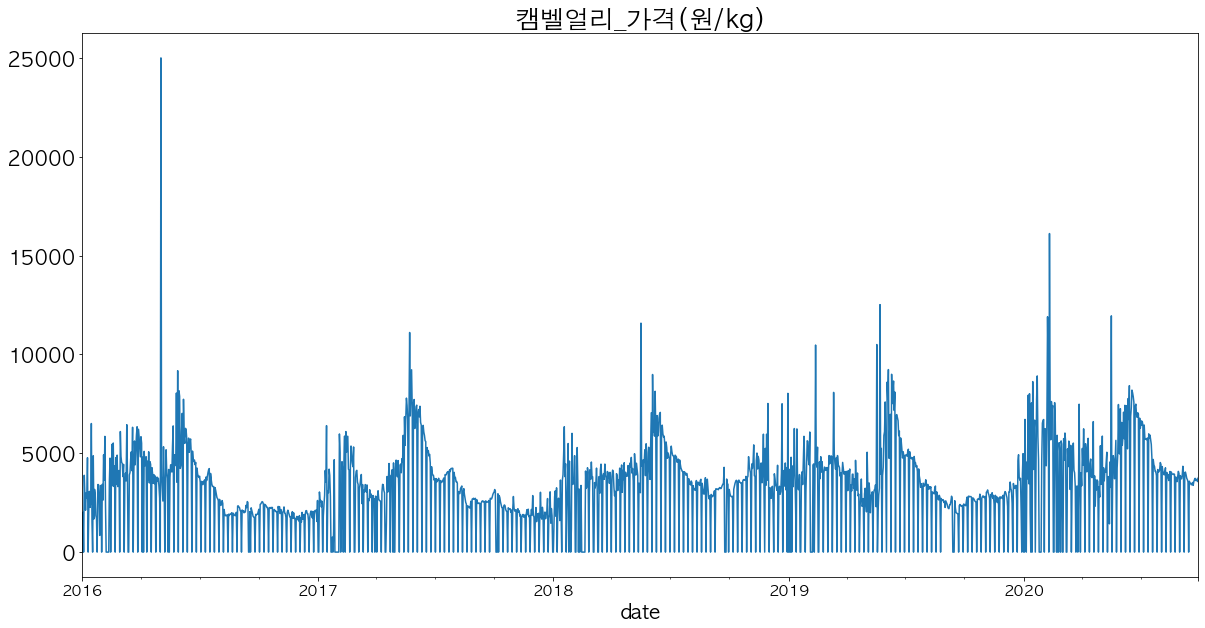

In [9]:
plt.title('캠벨얼리_가격(원/kg)', fontsize=25)
plt.xlabel('기간', fontsize = 20)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 20)
df['캠벨얼리_가격(원/kg)'].plot(figsize=(20,10))

<AxesSubplot:title={'center':'샤인마스캇_가격(원/kg)'}, xlabel='date'>

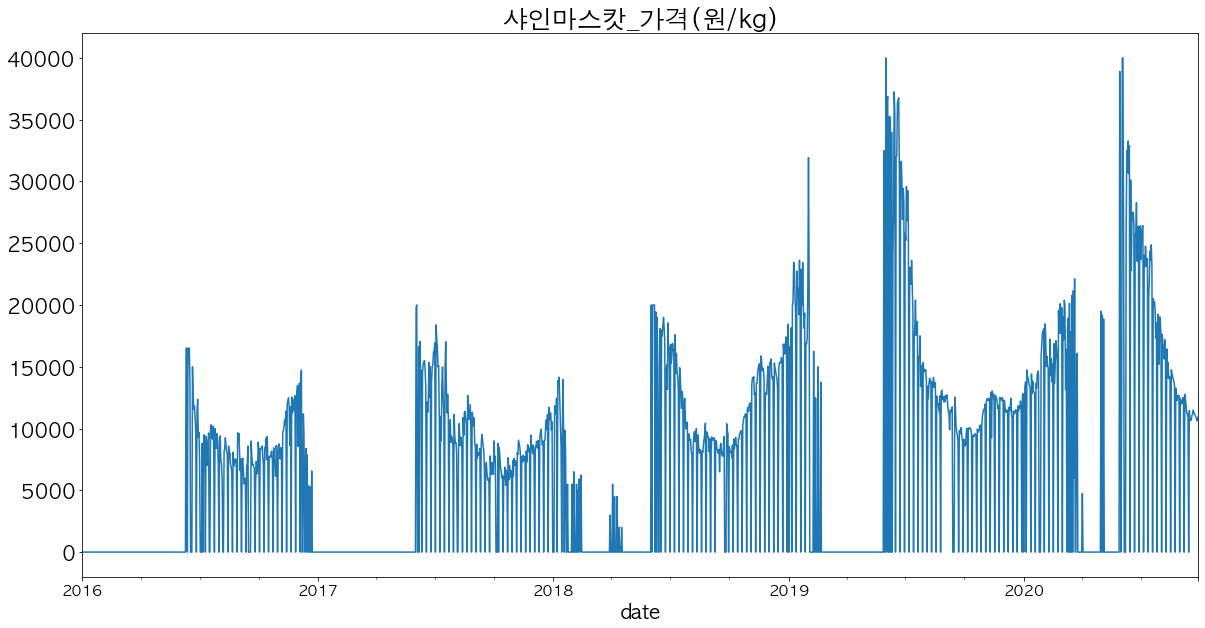

In [10]:
plt.title('샤인마스캇_가격(원/kg)', fontsize=25)
plt.xlabel('기간', fontsize = 20)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 20)
df['샤인마스캇_가격(원/kg)'].plot(figsize=(20,10))

(array([822., 123., 383., 239.,  98.,  46.,  26.,  14.,   9.,  10.]),
 array([    0.,  4000.,  8000., 12000., 16000., 20000., 24000., 28000.,
        32000., 36000., 40000.]),
 <BarContainer object of 10 artists>)

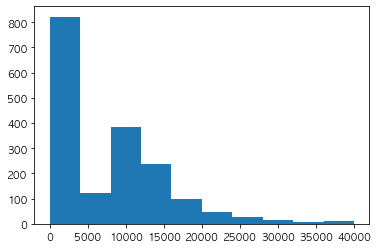

In [26]:
# 샤인머스켓 히스토그램 -> 이상치 확인 -> 외부데이터 추가하는 방법

# shinemuscat[shinemuscat['샤인마스캇_가격(원/kg)' ] < 30000]
plt.hist(shinemuscat['샤인마스캇_가격(원/kg)' ])
# plt.xscale('log')

In [17]:
shinemuscat['샤인마스캇_가격(원/kg)' ].value_counts()

0.0        819
20000.0      6
5500.0       5
16500.0      5
15000.0      4
          ... 
9912.0       1
11157.0      1
11727.0      1
10688.0      1
10178.0      1
Name: 샤인마스캇_가격(원/kg), Length: 903, dtype: int64

## 농산물 가격 분포
특이값이 많이 포함되어 있음 (이상치가 아니라 우리가 예측해야 하는 값)

<AxesSubplot:>

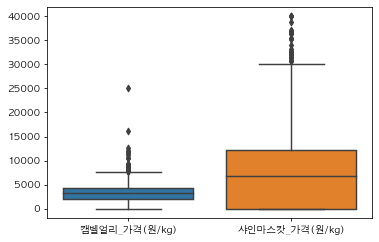

In [11]:
feature = df[['캠벨얼리_가격(원/kg)','샤인마스캇_가격(원/kg)' ]].columns

fig = plt.figure(dpi=70)
plt.xticks(rotation = 0)
sns.boxplot(data = df[feature])

## 특이값 발생 원인


캠벨얼리 가격 0이 아닐경우만 시각화 
> FTA로 국내 포도 농가 급감 (FTA로 수입 포도 물량이 급증하면서 포도 가격이 하락한 게 주원인, 캠벨얼리가 지난 2011년 4천716원에서 지난해 3천590원) -> 거래량 줄어들면서 가격 상승

[재배방법 및 시기](https://www.ganghwa.go.kr/open_content/agriculture/info/technic/grape.jsp)<br>
**수확시기 8월 하(캠벨얼리) 9월 중(거봉)**

<AxesSubplot:xlabel='date'>

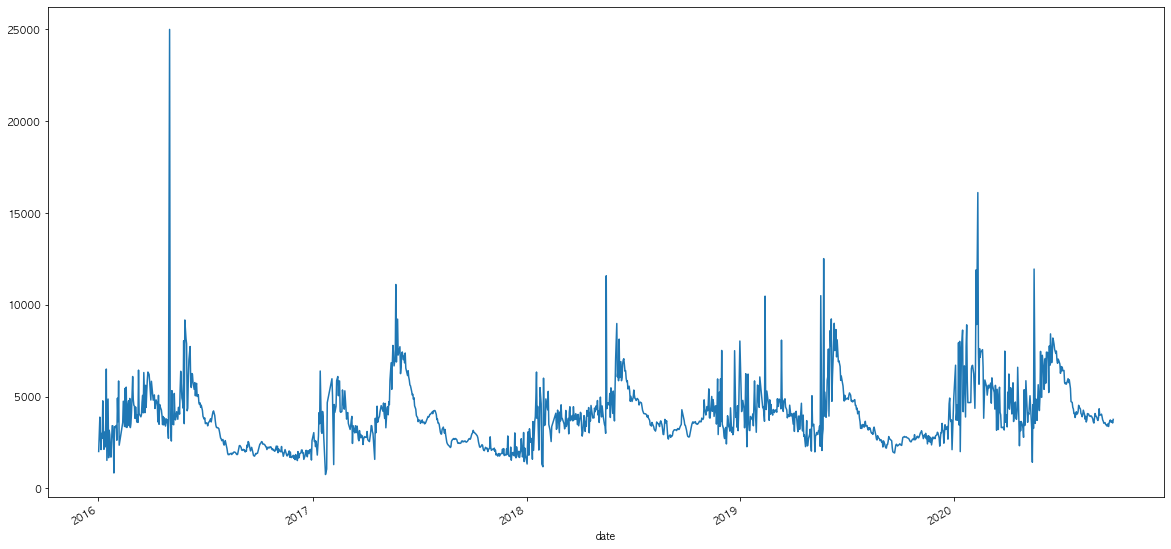

In [12]:
df[df['캠벨얼리_가격(원/kg)'] > 1]['캠벨얼리_가격(원/kg)'].plot(figsize=(20,10))

**샤인마스캇** 가격 0이 아닐경우만 시각화

> 가격 폭등 2017년부터 매년 50% 이상 매출이 늘고 있다. 농경연은 이달 출하하는 샤인머스캣의 가격이 2㎏에 1만7000 ~ 1만9000원 수준으로 전년 가격 대비 10~20% 가량 내려갈 것으로 전망

[재배방법 및 시기](https://lib.rda.go.kr/search/mediaView.do?sysdiv=CAT&ctrl=000000631955)<br>
**수확시기: 8월말 ~ 10월 중순**

<AxesSubplot:xlabel='date'>

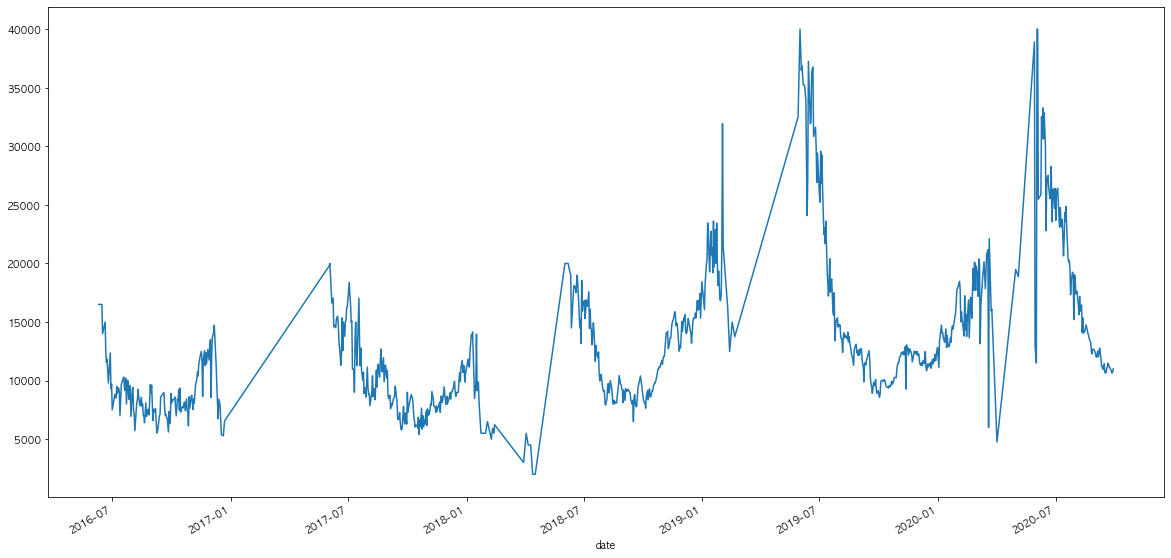

In [13]:
df[df['샤인마스캇_가격(원/kg)'] > 1]['샤인마스캇_가격(원/kg)'].plot(figsize=(20,10))

## [가격 추세 결론]
> 1. 농산물 품목별 계절 패턴이 뚜렷 <br>
2. 품목별로 다른 분포를 보임 <br>
**=>  시계열 반영 모델 및 폼목별 모델 생성**

## [가격 분포 결론]
> 1. 특이값 분포<br>
2. 외부 요인에 의한 이상치 <br>
**=> 농산물 품목별 영향을 미치는 외부 요인 추가**

## [특이값 발생 결론]
>**=> 날씨의 영향 받음**

> **캠벨얼리** 가격 0이 아닐경우만 시각화 <br>
FTA로 국내 포도 농가 급감 (FTA로 수입 포도 물량이 급증하면서 포도 가격이 하락한 게 주원인, 캠벨얼리가 지난 2011년 4천716원에서 지난해 3천590원) -> 거래량 줄어들면서 가격 상승 <br>
[재배방법 및 시기](https://www.ganghwa.go.kr/open_content/agriculture/info/technic/grape.jsp)<br>
**수확시기 8월 하(캠벨얼리) 9월 중(거봉)**


> **샤인마스캇** 가격 0이 아닐경우만 시각화<br>
가격 폭등 2017년부터 매년 50% 이상 매출이 늘고 있다. 농경연은 이달 출하하는 샤인머스캣의 가격이 2㎏에 1만7000 ~ 1만9000원 수준으로 전년 가격 대비 10~20% 가량 내려갈 것으로 전망
 <br>
[재배방법 및 시기](https://lib.rda.go.kr/search/mediaView.do?sysdiv=CAT&ctrl=000000631955)<br>
**수확시기: 8월말 ~ 10월 중순**



## Summary Statistics 확인(비시각화)

In [14]:
# 캠벨얼리 비시각화
grape_train.describe()

,캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),소비자물가지수,자동차용경유,재배지역_평균기온,재배지역_평균운량,재배지역_일강수량,재배지역_일교차,샤인마스캇_거래량(kg),수출(중량),수출(금액),수입(중량),수입(금액),재배면적(ha),최저시급,경제활동인구,실업률 (%)
count,1.733000e+03,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1.733000e+03,1733.000000,1733.000000,1733.000000,1733.000000
mean,1.183558e+05,3214.508944,98.296488,1284.769913,13.549862,2.959937,3.640364,11.089937,6690.233756,4032.771102,37939.022043,202373.205574,5.620692e+05,13350.826313,7331.136757,960188.675130,0.130006
std,2.465254e+05,2150.772383,1.556293,100.238503,9.939853,2.880286,10.663743,3.757588,24296.175358,4844.407819,48541.196622,178504.801358,5.115530e+05,846.013076,995.417172,14159.459741,0.017508
min,0.000000e+00,0.000000,95.232000,1058.750000,-11.310000,0.000000,0.000000,2.390000,0.000000,39.220690,134.965517,44707.270000,9.710637e+04,12676.000000,6030.000000,918310.000000,0.100000
25%,9.742000e+02,2053.000000,97.366000,1220.280000,4.780000,0.800000,0.000000,8.520000,0.000000,507.174194,1663.741935,80399.758065,2.012466e+05,12795.000000,6470.000000,952310.000000,0.120000
50%,4.541600e+03,3318.000000,98.855000,1293.630000,14.630000,1.640000,0.000000,10.910000,126.000000,1637.540000,13226.966667,128144.626667,3.676184e+05,13107.000000,7540.000000,963551.000000,0.130000
75%,7.459400e+04,4302.000000,99.491000,1361.780000,22.160000,5.050000,1.360000,13.530000,2782.000000,5873.200000,52675.419355,238366.954839,6.320523e+05,13183.000000,8350.000000,968793.000000,0.140000
max,1.490337e+06,25000.000000,100.740000,1495.760000,30.990000,10.000000,131.640000,22.060000,382263.400000,19598.766667,181332.266667,843743.880000,2.323876e+06,14946.000000,8590.000000,984310.000000,0.170000


In [15]:
# 샤인마스캇 비시각화
shinemuscat_train.describe()

,샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg),소비자물가지수,자동차용경유,재배지역_평균기온,재배지역_평균운량,재배지역_일강수량,재배지역_일교차,수출(중량),수출(금액),수입(중량),수입(금액),재배면적(ha),블루베리_거래물량(kg),최저시급,경제활동인구,실업률 (%)
count,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1.733000e+03,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000
mean,6690.233756,6989.684939,98.296488,1284.769913,14.079365,2.401166,3.337323,11.039342,4032.771102,37939.022043,202373.205574,5.620692e+05,13350.826313,93.403081,7331.136757,960188.675130,0.130006
std,24296.175358,7921.093712,1.556293,100.238503,9.683227,3.260553,11.582086,3.933723,4844.407819,48541.196622,178504.801358,5.115530e+05,846.013076,80.697243,995.417172,14159.459741,0.017508
min,0.000000,0.000000,95.232000,1058.750000,-10.280000,0.000000,0.000000,1.460000,39.220690,134.965517,44707.270000,9.710637e+04,12676.000000,9.890000,6030.000000,918310.000000,0.100000
25%,0.000000,0.000000,97.366000,1220.280000,5.360000,0.000000,0.000000,8.400000,507.174194,1663.741935,80399.758065,2.012466e+05,12795.000000,53.550000,6470.000000,952310.000000,0.120000
50%,126.000000,6863.000000,98.855000,1293.630000,14.920000,0.000000,0.000000,10.860000,1637.540000,13226.966667,128144.626667,3.676184e+05,13107.000000,55.340000,7540.000000,963551.000000,0.130000
75%,2782.000000,12121.000000,99.491000,1361.780000,22.310000,5.060000,0.500000,13.660000,5873.200000,52675.419355,238366.954839,6.320523e+05,13183.000000,117.960000,8350.000000,968793.000000,0.140000
max,382263.400000,40000.000000,100.740000,1495.760000,32.030000,10.000000,142.570000,22.060000,19598.766667,181332.266667,843743.880000,2.323876e+06,14946.000000,257.190000,8590.000000,984310.000000,0.170000


## [Summary Statistics 결론]
> 1. 샤인마스캇의 가격의 편차가 캠벨얼리보다 큼 <br>
2. 수출보다 수입의 금액이 더큼 <br>
**=> 데이터의 편차가 크고 단위가 다름 -> 정규화 -> RobustScaler**

----


##  요일, 년, 월 컬럼 추가

In [16]:
grape_train.date = pd.to_datetime(grape_train.date)
grape_train_date = pd.concat([grape_train, pd.get_dummies(grape_train['요일'])], axis = 1)
grape_train_date['년'] = grape_train['date'].dt.year 
grape_train_date['월'] = grape_train['date'].dt.month 

shinemuscat_train.date = pd.to_datetime(shinemuscat_train.date)
shinemuscat_train_date = pd.concat([shinemuscat_train, pd.get_dummies(shinemuscat_train['요일'])], axis = 1)
shinemuscat_train_date['년'] = shinemuscat_train['date'].dt.year 
shinemuscat_train_date['월'] = shinemuscat_train['date'].dt.month 

In [17]:
display(grape_train_date.head(2))
display(grape_train_date.tail(2))
print(grape_train_date.shape)

display(shinemuscat_train_date.head(2))
display(shinemuscat_train_date.tail(2))
print(shinemuscat_train_date.shape)

,date,요일,캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),소비자물가지수,자동차용경유,재배지역_평균기온,재배지역_평균운량,재배지역_일강수량,재배지역_일교차,...,실업률 (%),금요일,목요일,수요일,월요일,일요일,토요일,화요일,년,월
0,2016-01-01,금요일,0.0,0.0,95.232,1188.71,0.30,1.11,0.0,12.05,...,0.13,1,0,0,0,0,0,0,2016,1
1,2016-01-02,토요일,880.0,2014.0,95.232,1187.91,3.61,1.31,0.0,13.11,...,0.13,0,0,0,0,0,1,0,2016,1


,date,요일,캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),소비자물가지수,자동차용경유,재배지역_평균기온,재배지역_평균운량,재배지역_일강수량,재배지역_일교차,...,실업률 (%),금요일,목요일,수요일,월요일,일요일,토요일,화요일,년,월
1731,2020-09-27,일요일,21717.0,3567.0,100.74,1145.23,18.76,1.71,0.0,11.36,...,0.12,0,0,0,0,1,0,0,2020,9
1732,2020-09-28,월요일,601841.0,3761.0,100.74,1144.85,17.45,2.11,0.0,13.38,...,0.12,0,0,0,1,0,0,0,2020,9


(1733, 28)


,date,요일,샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg),소비자물가지수,자동차용경유,재배지역_평균기온,재배지역_평균운량,재배지역_일강수량,재배지역_일교차,...,실업률 (%),금요일,목요일,수요일,월요일,일요일,토요일,화요일,년,월
0,2016-01-01,금요일,0.0,0.0,95.232,1188.71,0.50,0.0,0.0,13.40,...,0.13,1,0,0,0,0,0,0,2016,1
1,2016-01-02,토요일,0.0,0.0,95.232,1187.91,2.29,0.0,0.0,14.18,...,0.13,0,0,0,0,0,1,0,2016,1


,date,요일,샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg),소비자물가지수,자동차용경유,재배지역_평균기온,재배지역_평균운량,재배지역_일강수량,재배지역_일교차,...,실업률 (%),금요일,목요일,수요일,월요일,일요일,토요일,화요일,년,월
1731,2020-09-27,일요일,9734.0,10699.0,100.74,1145.23,17.98,2.26,0.0,11.48,...,0.12,0,0,0,0,1,0,0,2020,9
1732,2020-09-28,월요일,382263.4,10998.0,100.74,1144.85,16.29,2.66,0.0,13.96,...,0.12,0,0,0,1,0,0,0,2020,9


(1733, 28)


## 1. 캠벨얼리 EDA (grape_train)
### 1-1. 캠벨얼리 거래량이 가격에 영향을 끼치는가?
> **[결론]생산량과 가격은 상관관계 거의 없음**

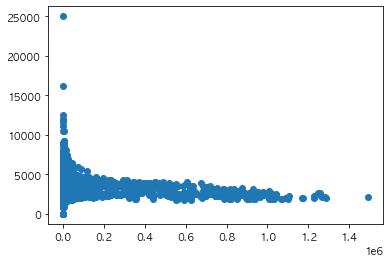

In [18]:
x = grape_train['캠벨얼리_거래량(kg)']
y = grape_train['캠벨얼리_가격(원/kg)']

plt.plot(x, y, 'o')
plt.show()

### 1-2. 캠벨얼리의 2019년도 거래량은 2020년도 수확시기(8월)에 가격의 영향을 끼치는가?
> [결론] 가격과 수확시기는 상관관계 조금 유의하다 볼 수 있음

In [19]:
print(grape_train_date.loc[grape_train_date['년'] == 2016, ['캠벨얼리_거래량(kg)']].mean())
print(grape_train_date.loc[grape_train_date['년'] == 2017, ['캠벨얼리_거래량(kg)']].mean())
print(grape_train_date.loc[grape_train_date['년'] == 2018, ['캠벨얼리_거래량(kg)']].mean())
print(grape_train_date.loc[grape_train_date['년'] == 2019, ['캠벨얼리_거래량(kg)']].mean())
print(grape_train_date.loc[grape_train_date['년'] == 2020, ['캠벨얼리_거래량(kg)']].mean())

캠벨얼리_거래량(kg)    151953.232514
dtype: float64
캠벨얼리_거래량(kg)    128875.319178
dtype: float64
캠벨얼리_거래량(kg)    100920.615616
dtype: float64
캠벨얼리_거래량(kg)    111851.179726
dtype: float64
캠벨얼리_거래량(kg)    91156.276471
dtype: float64


In [20]:
ouput = pd.DataFrame({'년':[2016, 2017, 2018, 2019, 2020],
                     '연간 거래량평균': [151953.232514, 128875.319178, 100920.615616, 111851.179726, 91156.276471]})
output = ouput[ouput['년'] < 2020] # 2020년을 제외하고 연도별 공급량 추출
output = output.iloc[:,1].reset_index(drop=True)
output

0    151953.232514
1    128875.319178
2    100920.615616
3    111851.179726
Name: 연간 거래량평균, dtype: float64

In [21]:
print(grape_train_date.loc[(grape_train_date['년'] == 2016) &(grape_train_date['월'] == 8), ['캠벨얼리_가격(원/kg)']].mean())
print(grape_train_date.loc[(grape_train_date['년'] == 2017) &(grape_train_date['월'] == 8), ['캠벨얼리_가격(원/kg)']].mean())
print(grape_train_date.loc[(grape_train_date['년'] == 2018) &(grape_train_date['월'] == 8), ['캠벨얼리_가격(원/kg)']].mean())
print(grape_train_date.loc[(grape_train_date['년'] == 2019) &(grape_train_date['월'] == 8), ['캠벨얼리_가격(원/kg)']].mean())
print(grape_train_date.loc[(grape_train_date['년'] == 2020) &(grape_train_date['월'] == 8), ['캠벨얼리_가격(원/kg)']].mean())

캠벨얼리_가격(원/kg)    1820.645161
dtype: float64
캠벨얼리_가격(원/kg)    2534.548387
dtype: float64
캠벨얼리_가격(원/kg)    2920.548387
dtype: float64
캠벨얼리_가격(원/kg)    2625.064516
dtype: float64
캠벨얼리_가격(원/kg)    3315.16129
dtype: float64


In [22]:
price_yang = pd.DataFrame({'년':[2016, 2017, 2018, 2019, 2020],
                     '연간 가격평균': [1820.645161, 2534.548387, 2920.548387, 2625.064516, 3315.16129]})
price_yang = price_yang[ouput['년'] != 2016] # 2016년을 제외하고 연도별 공급량 추출
price_yang = price_yang.iloc[:,1].reset_index(drop=True)
price_yang

0    2534.548387
1    2920.548387
2    2625.064516
3    3315.161290
Name: 연간 가격평균, dtype: float64

In [23]:
output = pd.DataFrame(output)
price_yang = pd.DataFrame(price_yang)

data = pd.concat([output, price_yang], axis = 1)

In [24]:
data.corr()

,연간 거래량평균,연간 가격평균
연간 거래량평균,1.000000,-0.380633
연간 가격평균,-0.380633,1.000000


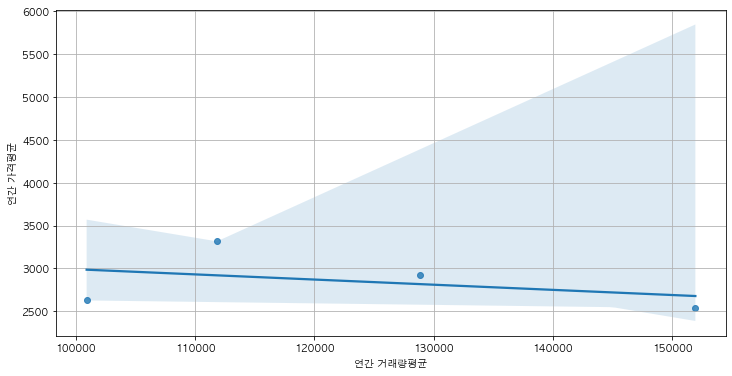

In [25]:
from statsmodels.formula.api import ols

data_x = data['연간 거래량평균']
data_y = data['연간 가격평균']

#pyplot과 seaborn으로 회귀그래프 
plt.rcParams["figure.figsize"] = (12, 6)
sns.regplot(x=data_x, y=data_y, data=data)
plt.grid()
plt.show()

### 1-3. 캠벨얼리의 가격은 날씨데이터(계절)에 영향을 끼치는가?
> 가격과 날씨데이터간의 상관관계 유의하지 않음

In [26]:
grape_weather = grape_train_date[['년','월','캠벨얼리_가격(원/kg)']]
grape_weather.corr()

,년,월,캠벨얼리_가격(원/kg)
년,1.000000,-0.109649,0.186223
월,-0.109649,1.000000,-0.167286
캠벨얼리_가격(원/kg),0.186223,-0.167286,1.000000


In [27]:
grape_season = grape_weather.copy()

# 계절 = 0: 겨울(12~2월) // 1 : 봄(3~5월) // 2: 여름(6~8월) // 3: 가을(9~11월)
grape_season['계절'] = (grape_season['월'] // 3 % 4) 
grape_season[200:]

,년,월,캠벨얼리_가격(원/kg),계절
200,2016,7,3676.0,2
201,2016,7,3432.0,2
202,2016,7,3323.0,2
203,2016,7,3309.0,2
204,2016,7,3318.0,2
...,...,...,...,...
1728,2020,9,3620.0,3
1729,2020,9,3618.0,3
1730,2020,9,3691.0,3
1731,2020,9,3567.0,3


In [28]:
season_list = []
for season in grape_season['계절']:
    if season == 0:
        season_list.append('겨울')
    elif season == 1:
        season_list.append('봄')
    elif season == 2:
        season_list.append('여름')
    else:
        season_list.append('가을')

grape_season['계절_한글'] = season_list

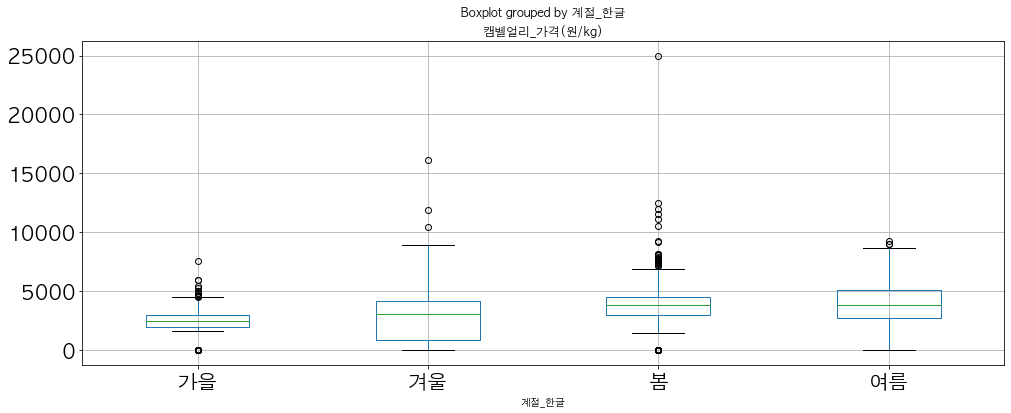

In [29]:
grape_season.boxplot(column='캠벨얼리_가격(원/kg)', by = '계절_한글', figsize=(16,6) , fontsize=20)
grape_season.drop(columns=['계절_한글'], inplace=True)

### [계절 결론]
> 겨울의 편차가 크고, 가을의 편차가 적음 -> 수확시기의 영향을 받음

In [30]:
grape_season.iloc[:,2:].corr()

,캠벨얼리_가격(원/kg),계절
캠벨얼리_가격(원/kg),1.000000,-0.056574
계절,-0.056574,1.000000


<AxesSubplot:title={'center':'캠벨얼리_가격(원/kg)'}, xlabel='월'>

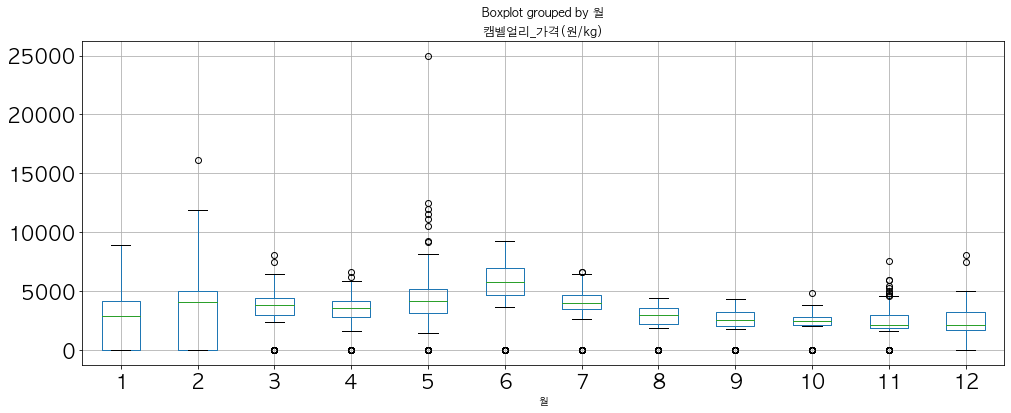

In [31]:
grape_season.boxplot(column='캠벨얼리_가격(원/kg)', by = '월', figsize=(16,6), fontsize=20)

<AxesSubplot:title={'center':'캠벨얼리_가격(원/kg)'}, xlabel='년'>

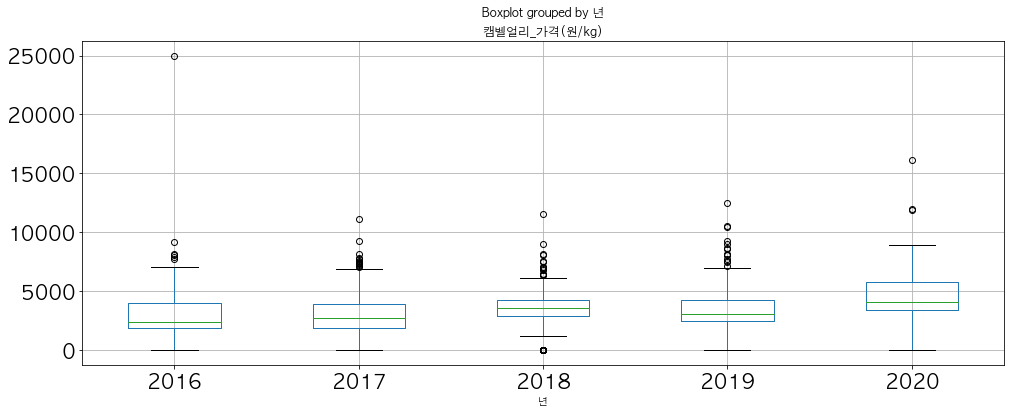

In [32]:
grape_season.boxplot(column='캠벨얼리_가격(원/kg)', by = '년', figsize=(16,6), fontsize=20)

In [33]:
grape_season.iloc[:,2:].corr()

,캠벨얼리_가격(원/kg),계절
캠벨얼리_가격(원/kg),1.000000,-0.056574
계절,-0.056574,1.000000


----

## 2. 샤인머스캇 EDA (shinemuscat_train)
### 2-1. 샤인머스캇 거래량이 가격에 영향을 끼치는가?
> 생산량과 가격은 상관관계 거의 없음

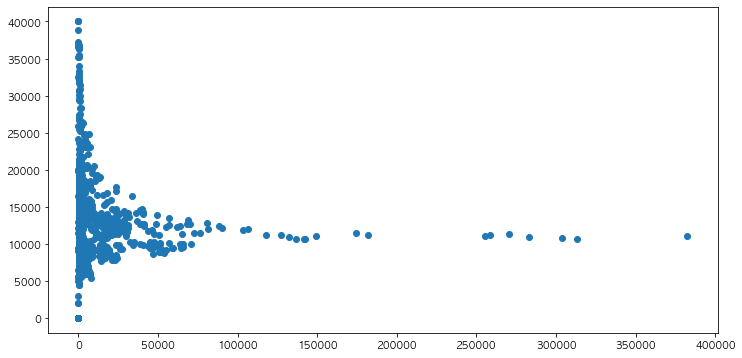

In [34]:
x = shinemuscat_train['샤인마스캇_거래량(kg)']
y = shinemuscat_train['샤인마스캇_가격(원/kg)']

plt.plot(x, y, 'o')
plt.show()

In [35]:
corr = shinemuscat.iloc[:,:4].corr(method='pearson')
corr

,샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
샤인마스캇_거래량(kg),1.000000,0.153007
샤인마스캇_가격(원/kg),0.153007,1.000000


### 2-2. 샤인머스캇의 전년도 생산량은 당해 연도 9월 가격에 영향을 끼치는가?
> **[결론] 전년산 생산량과 가격의 상관관계 있다고할 수 있음**

In [36]:
print(shinemuscat_train_date.loc[shinemuscat_train_date['년'] == 2016, ['샤인마스캇_거래량(kg)']].mean())
print(shinemuscat_train_date.loc[shinemuscat_train_date['년'] == 2017, ['샤인마스캇_거래량(kg)']].mean())
print(shinemuscat_train_date.loc[shinemuscat_train_date['년'] == 2018, ['샤인마스캇_거래량(kg)']].mean())
print(shinemuscat_train_date.loc[shinemuscat_train_date['년'] == 2019, ['샤인마스캇_거래량(kg)']].mean())
print(shinemuscat_train_date.loc[shinemuscat_train_date['년'] == 2020, ['샤인마스캇_거래량(kg)']].mean())

샤인마스캇_거래량(kg)    396.363388
dtype: float64
샤인마스캇_거래량(kg)    1122.328767
dtype: float64
샤인마스캇_거래량(kg)    3398.090411
dtype: float64
샤인마스캇_거래량(kg)    11045.872329
dtype: float64
샤인마스캇_거래량(kg)    21203.712132
dtype: float64


In [37]:
ouput = pd.DataFrame({'년':[2016, 2017, 2018, 2019, 2020],
                     '연간 거래량평균': [396.363388, 1122.328767, 3398.090411, 11045.872329, 21203.712132]})
output = ouput[ouput['년'] < 2020] # 2020년을 제외하고 연도별 공급량 추출
output = output.iloc[:,1].reset_index(drop=True)
output

0      396.363388
1     1122.328767
2     3398.090411
3    11045.872329
Name: 연간 거래량평균, dtype: float64

In [38]:
print(shinemuscat_train_date.loc[(shinemuscat_train_date['년'] == 2016) &(shinemuscat_train_date['월'] == 8), ['샤인마스캇_가격(원/kg)']].mean())
print(shinemuscat_train_date.loc[(shinemuscat_train_date['년'] == 2017) &(shinemuscat_train_date['월'] == 8), ['샤인마스캇_가격(원/kg)']].mean())
print(shinemuscat_train_date.loc[(shinemuscat_train_date['년'] == 2018) &(shinemuscat_train_date['월'] == 8), ['샤인마스캇_가격(원/kg)']].mean())
print(shinemuscat_train_date.loc[(shinemuscat_train_date['년'] == 2019) &(shinemuscat_train_date['월'] == 8), ['샤인마스캇_가격(원/kg)']].mean())
print(shinemuscat_train_date.loc[(shinemuscat_train_date['년'] == 2020) &(shinemuscat_train_date['월'] == 8), ['샤인마스캇_가격(원/kg)']].mean())

샤인마스캇_가격(원/kg)    6664.741935
dtype: float64
샤인마스캇_가격(원/kg)    8559.064516
dtype: float64
샤인마스캇_가격(원/kg)    7776.483871
dtype: float64
샤인마스캇_가격(원/kg)    11425.645161
dtype: float64
샤인마스캇_가격(원/kg)    12225.419355
dtype: float64


In [39]:
price_yang = pd.DataFrame({'년':[2016, 2017, 2018, 2019, 2020],
                     '연간 가격평균': [6664.741935, 8559.064516, 7776.483871, 11425.645161, 12225.419355]})
price_yang = price_yang[ouput['년'] != 2016] # 2016년을 제외하고 연도별 공급량 추출
price_yang = price_yang.iloc[:,1].reset_index(drop=True)
price_yang

0     8559.064516
1     7776.483871
2    11425.645161
3    12225.419355
Name: 연간 가격평균, dtype: float64

In [40]:
output = pd.DataFrame(output)
price_yang = pd.DataFrame(price_yang)

data = pd.concat([output, price_yang], axis = 1)

In [41]:
data.corr()

,연간 거래량평균,연간 가격평균
연간 거래량평균,1.000000,0.836003
연간 가격평균,0.836003,1.000000


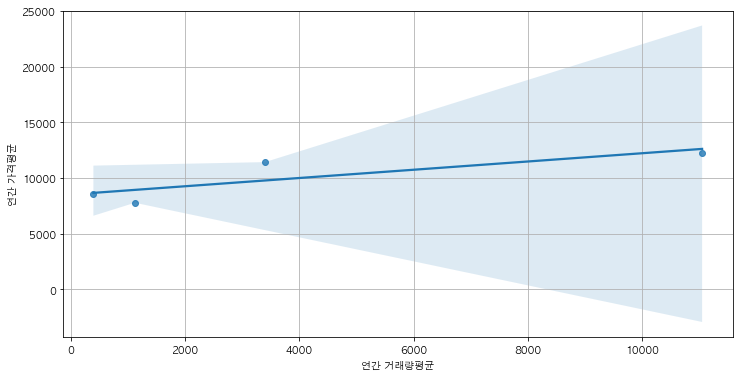

In [42]:
from statsmodels.formula.api import ols

data_x = data['연간 거래량평균']
data_y = data['연간 가격평균']

#pyplot과 seaborn으로 회귀그래프 
plt.rcParams["figure.figsize"] = (12, 6)
sns.regplot(x=data_x, y=data_y, data=data)
plt.grid()
plt.show()

### 2-4. 샤인머스캇의 가격은 날씨데이터(계절)에 영향을 끼치는가?

In [43]:
shinemuscat_weather = shinemuscat_train_date[['년','월','샤인마스캇_가격(원/kg)']]
shinemuscat_weather.corr()

,년,월,샤인마스캇_가격(원/kg)
년,1.000000,-0.109649,0.338260
월,-0.109649,1.000000,0.267494
샤인마스캇_가격(원/kg),0.338260,0.267494,1.000000


In [44]:
shinemuscat_season = shinemuscat_weather.copy()

# 계절 = 0: 겨울(12~2월) // 1 : 봄(3~5월) // 2: 여름(6~8월) // 3: 가을(9~11월)
shinemuscat_season['계절'] = (shinemuscat_season['월'] // 3 % 4) 
shinemuscat_season[200:]

,년,월,샤인마스캇_가격(원/kg),계절
200,2016,7,10305.0,2
201,2016,7,9281.0,2
202,2016,7,9156.0,2
203,2016,7,10195.0,2
204,2016,7,8000.0,2
...,...,...,...,...
1728,2020,9,10940.0,3
1729,2020,9,10844.0,3
1730,2020,9,10636.0,3
1731,2020,9,10699.0,3


In [45]:
season_list = []
for season in shinemuscat_season['계절']:
    if season == 0:
        season_list.append('겨울')
    elif season == 1:
        season_list.append('봄')
    elif season == 2:
        season_list.append('여름')
    else:
        season_list.append('가을')

shinemuscat_season['계절_한글'] = season_list

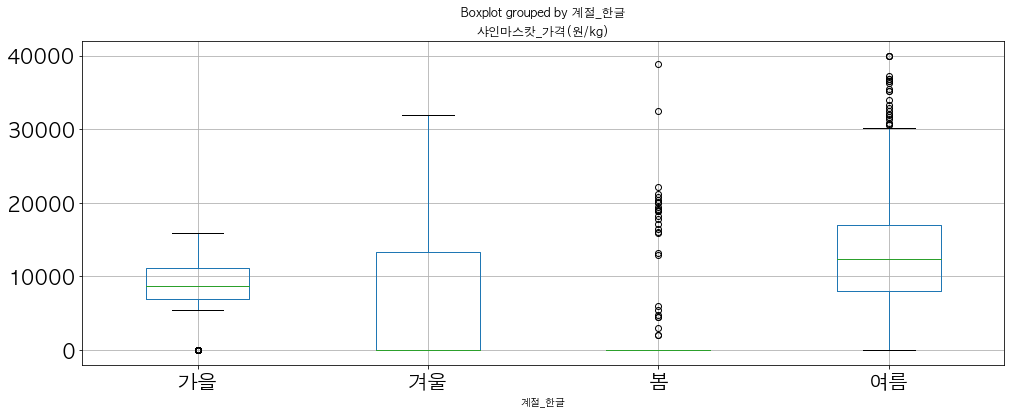

In [46]:
shinemuscat_season.boxplot(column='샤인마스캇_가격(원/kg)', by = '계절_한글', figsize=(16,6) , fontsize=20)
shinemuscat_season.drop(columns=['계절_한글'], inplace=True)

### [계절 결론]
> 겨울의 편차가 크고, 가을의 편차가 적음 -> 수확시기의 영향을 받음

In [47]:
shinemuscat_season.iloc[:,2:].corr()

,샤인마스캇_가격(원/kg),계절
샤인마스캇_가격(원/kg),1.000000,0.253827
계절,0.253827,1.000000


<AxesSubplot:title={'center':'샤인마스캇_가격(원/kg)'}, xlabel='월'>

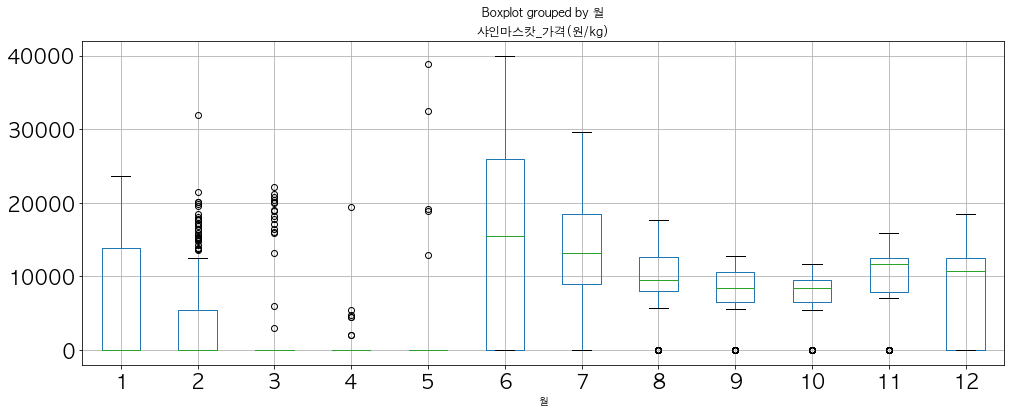

In [48]:
shinemuscat_season.boxplot(column='샤인마스캇_가격(원/kg)', by = '월', figsize=(16,6), fontsize=20)

<AxesSubplot:title={'center':'샤인마스캇_가격(원/kg)'}, xlabel='년'>

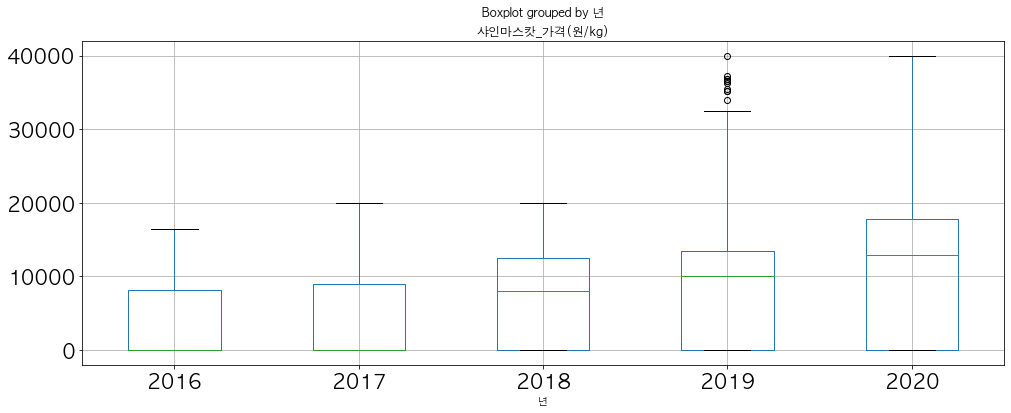

In [49]:
shinemuscat_season.boxplot(column='샤인마스캇_가격(원/kg)', by = '년', figsize=(16,6), fontsize=20)

In [50]:
shinemuscat_season.iloc[:,2:].corr()

,샤인마스캇_가격(원/kg),계절
샤인마스캇_가격(원/kg),1.000000,0.253827
계절,0.253827,1.000000


----

----

# Data Preproceesing (df = train, test & grape+shinemuscat)


- 파생변수 생성 (17일까지, git 업로드)
    - 1주전 , 2주전 가격 + 전년도 평균, 계절 평균 가격
    - 1주전 , 2주전 거래량 + 전년도 평균, 계절 평균 거래량
    - 날짜의 데이터 - [계절 파생변수 생성](https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime) (현재 날짜 기준: 입춘, 입동 …)
       

In [178]:
preprocessing = df[['date','요일', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)', '샤인마스캇_거래량(kg)','샤인마스캇_가격(원/kg)']]
print(preprocessing.shape)
preprocessing.head(2)

(1770, 6)


,date,요일,캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
0,2016-01-01,금요일,0.0,0.0,0.0,0.0
1,2016-01-02,토요일,880.0,2014.0,0.0,0.0


In [179]:
preprocessing.describe()

,캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
count,1.770000e+03,1770.000000,1770.000000,1770.000000
mean,1.180290e+05,3197.801695,8793.314746,7000.619774
std,2.444773e+05,2139.610264,29799.805896,7859.913795
min,0.000000e+00,0.000000,0.000000,0.000000
25%,9.900000e+02,2059.000000,0.000000,0.000000
50%,4.696100e+03,3285.500000,145.000000,7011.500000
75%,7.825415e+04,4275.750000,2977.500000,11984.000000
max,1.490337e+06,25000.000000,382263.400000,40000.000000


### 포도 값 15000원 이상 가격 -> 계절 평균으로 대체
> FTA로 인한 가격상승 -> 예측 어려움

In [180]:
preprocessing.date = pd.to_datetime(preprocessing.date)
preprocessing['월'] = preprocessing['date'].dt.month 
preprocessing['년'] = preprocessing['date'].dt.year 

# 계절 = 0: 겨울(12~2월) // 1 : 봄(3~5월) // 2: 여름(6~8월) // 3: 가을(9~11월)
preprocessing['계절'] = (preprocessing['월'] // 3 % 4) 
# preprocessing.drop(columns=['월','년'], inplace=True)
print(preprocessing.shape)
preprocessing.head(2)

(1770, 9)


,date,요일,캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg),월,년,계절
0,2016-01-01,금요일,0.0,0.0,0.0,0.0,1,2016,0
1,2016-01-02,토요일,880.0,2014.0,0.0,0.0,1,2016,0


In [181]:
preprocessing[preprocessing['캠벨얼리_가격(원/kg)'] > 15000]

,date,요일,캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg),월,년,계절
122,2016-05-02,월요일,25.0,25000.0,0.0,0.0,5,2016,1
1501,2020-02-10,월요일,234.0,16115.0,4784.4,13797.0,2,2020,0


In [183]:
print(round(preprocessing.loc[(preprocessing['계절'] == 1)&(preprocessing['년'] == 2016),'캠벨얼리_가격(원/kg)'].mean(), 2))
print(round(preprocessing.loc[(preprocessing['계절'] == 0)&(preprocessing['년'] == 2020),'캠벨얼리_가격(원/kg)'].mean(), 2))

4059.98
4490.2


In [185]:
preprocessing.loc[122, '캠벨얼리_가격(원/kg)'] = 4059.98
preprocessing.loc[1501, '캠벨얼리_가격(원/kg)'] = 4490.2

### 1, 2주전 거래량 & 가격 파생변수 생성

In [186]:
# 1주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~16, 17~23, ...
# index 기준 0~9는 농넷에서 찾아야 할 듯 합니다. so 2015년 12월 28부터 2015년 12월 31일까지 4일간의 데이터 찾아보자.

A = [];B = []
for x in range(10):
    A.append(0)
    B.append(0)

for y in range(246):
    s = 0;t = 0
    for z in range(7):
        s += preprocessing['캠벨얼리_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += preprocessing['캠벨얼리_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (preprocessing['캠벨얼리_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    v_2 = (preprocessing['캠벨얼리_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    for w in range(7):
        A.append(s / (7 - v_1))
        B.append(t / (7 - v_2))
for z in range(7):
    s += preprocessing['캠벨얼리_거래량(kg)'].iloc[1725 + z]
    t += preprocessing['캠벨얼리_가격(원/kg)'].iloc[1725 + z]
v_1 = (preprocessing['캠벨얼리_거래량(kg)'].iloc[1725:1732] == 0).sum()
v_2 = (preprocessing['캠벨얼리_가격(원/kg)'].iloc[1725:1732] == 0).sum()
A.append(s / (7 - v_1))
B.append(t / (7 - v_2))
Adf = pd.DataFrame(A, columns = ['캠벨얼리_거래량의_1주전_평균'])
Bdf = pd.DataFrame(B, columns = ['캠벨얼리_가격의_1주전_평균'])
preprocessing_1 = pd.concat([preprocessing, Adf, Bdf], axis=1)
# preprocessing_1

In [187]:
# 1주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~16, 17~23, ...
# index 기준 0~9는 농넷에서 찾아야 할 듯 합니다. so 2015년 12월 28부터 2015년 12월 31일까지 4일간의 데이터 찾아보자.

A = [];B = []
for x in range(10):
    A.append(0)
    B.append(0)

for y in range(246):
    s = 0;t = 0
    for z in range(7):
        s += preprocessing['샤인마스캇_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += preprocessing['샤인마스캇_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (preprocessing['샤인마스캇_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    v_2 = (preprocessing['샤인마스캇_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    for w in range(7):
        A.append(s / (7 - v_1))
        B.append(t / (7 - v_2))
for z in range(7):
    s += preprocessing['샤인마스캇_거래량(kg)'].iloc[1725 + z]
    t += preprocessing['샤인마스캇_가격(원/kg)'].iloc[1725 + z]
v_1 = (preprocessing['샤인마스캇_거래량(kg)'].iloc[1725:1732] == 0).sum()
v_2 = (preprocessing['샤인마스캇_가격(원/kg)'].iloc[1725:1732] == 0).sum()
A.append(s / (7 - v_1))
B.append(t / (7 - v_2))
Adf = pd.DataFrame(A, columns = ['샤인마스캇_거래량의_1주전_평균'])
Bdf = pd.DataFrame(B, columns = ['샤인마스캇_가격의_1주전_평균'])
preprocessing_1_shine = pd.concat([preprocessing_1, Adf, Bdf], axis=1)
# preprocessing_1_shine

In [188]:
# 2주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~23, 24~37, ...
# index 기준 0~16는 농넷에서 찾아야 할 듯 합니다. so 2015년 12월 21부터 2015년 12월 31일까지 11일간의 데이터 찾아보자.

C = [];D = []
for x in range(17):
    C.append(0)
    D.append(0)

for y in range(245):
    s = 0;t = 0
    for z in range(14):
        s += preprocessing['캠벨얼리_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += preprocessing['캠벨얼리_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (preprocessing['캠벨얼리_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    v_2 = (preprocessing['캠벨얼리_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    for w in range(7):
        C.append(s / (14 - v_1))
        D.append(t / (14 - v_2))
for z in range(14):
    s += preprocessing['캠벨얼리_거래량(kg)'].iloc[1718 + z]
    t += preprocessing['캠벨얼리_가격(원/kg)'].iloc[1718 + z]
v_1 = (preprocessing['캠벨얼리_거래량(kg)'].iloc[1718:1732] == 0).sum()
v_2 = (preprocessing['캠벨얼리_가격(원/kg)'].iloc[1718:1732] == 0).sum()
C.append(s / (14 - v_1))
D.append(t / (14 - v_2))
Cdf = pd.DataFrame(C, columns = ['캠벨얼리_거래량의_2주전_평균'])
Ddf = pd.DataFrame(D, columns = ['캠벨얼리_가격의_2주전_평균'])
preprocessing_2 = pd.concat([preprocessing_1_shine, Cdf, Ddf], axis=1)
# preprocessing_2

In [189]:
# 2주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~23, 24~37, ...
# index 기준 0~16는 농넷에서 찾아야 할 듯 합니다. so 2015년 12월 21부터 2015년 12월 31일까지 11일간의 데이터 찾아보자.

C = [];D = []
for x in range(17):
    C.append(0)
    D.append(0)

for y in range(245):
    s = 0;t = 0
    for z in range(14):
        s += preprocessing['샤인마스캇_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += preprocessing['샤인마스캇_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (preprocessing['샤인마스캇_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    v_2 = (preprocessing['샤인마스캇_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    for w in range(7):
        C.append(s / (14 - v_1))
        D.append(t / (14 - v_2))
for z in range(14):
    s += preprocessing['샤인마스캇_거래량(kg)'].iloc[1718 + z]
    t += preprocessing['샤인마스캇_가격(원/kg)'].iloc[1718 + z]
v_1 = (preprocessing['샤인마스캇_거래량(kg)'].iloc[1718:1732] == 0).sum()
v_2 = (preprocessing['샤인마스캇_가격(원/kg)'].iloc[1718:1732] == 0).sum()
C.append(s / (14 - v_1))
D.append(t / (14 - v_2))
Cdf = pd.DataFrame(C, columns = ['샤인마스캇_거래량의_2주전_평균'])
Ddf = pd.DataFrame(D, columns = ['샤인마스캇_가격의_2주전_평균'])
preprocessing_2_shine = pd.concat([preprocessing_2, Cdf, Ddf], axis=1)
preprocessing_2_shine

,date,요일,캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg),월,년,계절,캠벨얼리_거래량의_1주전_평균,캠벨얼리_가격의_1주전_평균,샤인마스캇_거래량의_1주전_평균,샤인마스캇_가격의_1주전_평균,캠벨얼리_거래량의_2주전_평균,캠벨얼리_가격의_2주전_평균,샤인마스캇_거래량의_2주전_평균,샤인마스캇_가격의_2주전_평균
0,2016-01-01,금요일,0.0,0.0,0.0,0.0,1,2016,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-02,토요일,880.0,2014.0,0.0,0.0,1,2016,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-03,일요일,0.0,0.0,0.0,0.0,1,2016,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-04,월요일,2703.8,3885.0,0.0,0.0,1,2016,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-05,화요일,8810.0,2853.0,0.0,0.0,1,2016,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,2020-10-31,토요일,34392.5,2920.0,111721.4,9735.0,10,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1766,2020-11-01,일요일,0.0,0.0,0.0,0.0,11,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1767,2020-11-02,월요일,37043.4,3039.0,88354.3,10205.0,11,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1768,2020-11-03,화요일,30158.5,3153.0,84795.0,10322.0,11,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
# 샤인머스켓 결측치 0으로 대체
preprocessing_2_shine = preprocessing_2_shine.fillna(0)

In [191]:
# 계절 = 0: 겨울(12~2월) // 1 : 봄(3~5월) // 2: 여름(6~8월) // 3: 가을(9~11월)
preprocessing_2_shine.계절.value_counts()

1    460
2    460
3    429
0    421
Name: 계절, dtype: int64

In [192]:
# 계절별 평균가격
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 0, '캠벨얼리_가격(원/kg)'].mean())
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 1, '캠벨얼리_가격(원/kg)'].mean())
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 2, '캠벨얼리_가격(원/kg)'].mean())
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 3, '캠벨얼리_가격(원/kg)'].mean())
print()
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 0, '샤인마스캇_가격(원/kg)'].mean())
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 1, '샤인마스캇_가격(원/kg)'].mean())
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 2, '샤인마스캇_가격(원/kg)'].mean())
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 3, '샤인마스캇_가격(원/kg)'].mean())

# 계절별 평균거래량
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 0, '캠벨얼리_거래량(kg)'].mean())
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 1, '캠벨얼리_거래량(kg)'].mean())
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 2, '캠벨얼리_거래량(kg)'].mean())
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 3, '캠벨얼리_거래량(kg)'].mean())
print()
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 0, '샤인마스캇_거래량(kg)'].mean())
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 1, '샤인마스캇_거래량(kg)'].mean())
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 2, '샤인마스캇_거래량(kg)'].mean())
print(preprocessing_2_shine.loc[preprocessing_2_shine.계절 == 3, '샤인마스캇_거래량(kg)'].mean())

2842.2570071258906
3579.573869565217
3839.013043478261
2373.902097902098

6313.852731591449
981.2630434782609
12609.756521739131
8114.4428904428905
2405.3494061757733
2851.8923913043495
208771.40739130432
257696.7601398601

2994.929928741092
16.745652173913044
4455.8189130434785
28545.2724941725


In [193]:
preprocessing_2_shine.columns

Index(['date', '요일', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)', '샤인마스캇_거래량(kg)',
       '샤인마스캇_가격(원/kg)', '월', '년', '계절', '캠벨얼리_거래량의_1주전_평균', '캠벨얼리_가격의_1주전_평균',
       '샤인마스캇_거래량의_1주전_평균', '샤인마스캇_가격의_1주전_평균', '캠벨얼리_거래량의_2주전_평균',
       '캠벨얼리_가격의_2주전_평균', '샤인마스캇_거래량의_2주전_평균', '샤인마스캇_가격의_2주전_평균'],
      dtype='object')

## 캠벨얼리, 샤인머스켓 파일저장

In [194]:
grape_df = preprocessing_2_shine[['date', '요일', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',
                                  '캠벨얼리_거래량의_1주전_평균', '캠벨얼리_가격의_1주전_평균', '캠벨얼리_거래량의_2주전_평균',
                                   '캠벨얼리_가격의_2주전_평균','계절']]
shinemuscat_df = preprocessing_2_shine[['date', '요일', '샤인마스캇_거래량(kg)',
                                       '샤인마스캇_가격(원/kg)','샤인마스캇_거래량의_1주전_평균', 
                                        '샤인마스캇_가격의_1주전_평균',  '샤인마스캇_거래량의_2주전_평균',
                                        '샤인마스캇_가격의_2주전_평균', '계절']]
grape_df.shape, shinemuscat_df.shape

((1770, 9), (1770, 9))

In [195]:
grape_df.to_csv(processed_path+'캠벨얼리_전처리후.csv', index = False)
shinemuscat_df.to_csv(processed_path+'샤인머스켓_전처리후.csv', index = False)

## 상관분석

### 전처리 후 상관분석

In [196]:
preprocessing_grape = preprocessing_2_shine[['date', '요일', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)', '캠벨얼리_거래량의_1주전_평균', '캠벨얼리_가격의_1주전_평균',
        '캠벨얼리_거래량의_2주전_평균','캠벨얼리_가격의_2주전_평균', '계절']]

preprocessing_shine = preprocessing_2_shine[['date', '요일', '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)', '샤인마스캇_거래량의_1주전_평균',
       '샤인마스캇_가격의_1주전_평균', '샤인마스캇_거래량의_2주전_평균', '샤인마스캇_가격의_2주전_평균', '계절']]

### 켐벨얼리 상관계수, p-value 검정

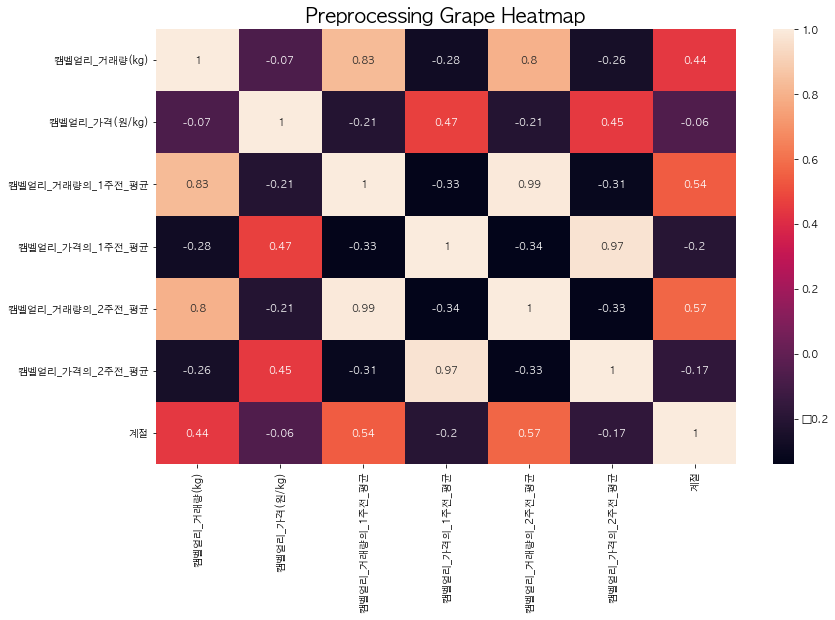

In [197]:
preprocessing_grape_corr = preprocessing_grape.copy()
preprocessing_grape_corr = preprocessing_grape_corr.corr().round(2)
ax = sns.heatmap(preprocessing_grape_corr, annot=True)
plt.title('Preprocessing Grape Heatmap', fontsize=20)
plt.show()

In [198]:
import scipy.stats as stats

Y =  preprocessing_grape['캠벨얼리_가격(원/kg)'].values

for item in ['캠벨얼리_거래량(kg)', '캠벨얼리_거래량의_1주전_평균', '캠벨얼리_가격의_1주전_평균',
        '캠벨얼리_거래량의_2주전_평균','캠벨얼리_가격의_2주전_평균', '계절']:
    print(item)
    X = preprocessing_grape[item].values
    print('Covariance:{:.2f}'.format(np.cov(X,Y)[0,1]))
    print('Correlation:{:.2f}'.format(stats.pearsonr(X,Y)[0]))
    print('P-value:{:.4f}'.format(stats.pearsonr(X,Y)[1]))
    print('\n')

캠벨얼리_거래량(kg)
Covariance:-35724345.50
Correlation:-0.07
P-value:0.0027


캠벨얼리_거래량의_1주전_평균
Covariance:-105648421.12
Correlation:-0.21
P-value:0.0000


캠벨얼리_가격의_1주전_평균
Covariance:1434960.26
Correlation:0.47
P-value:0.0000


캠벨얼리_거래량의_2주전_평균
Covariance:-108358182.25
Correlation:-0.21
P-value:0.0000


캠벨얼리_가격의_2주전_평균
Covariance:1362179.10
Correlation:0.45
P-value:0.0000


계절
Covariance:-138.93
Correlation:-0.06
P-value:0.0097




### 샤인머스켓 상관계수, p-value 검정

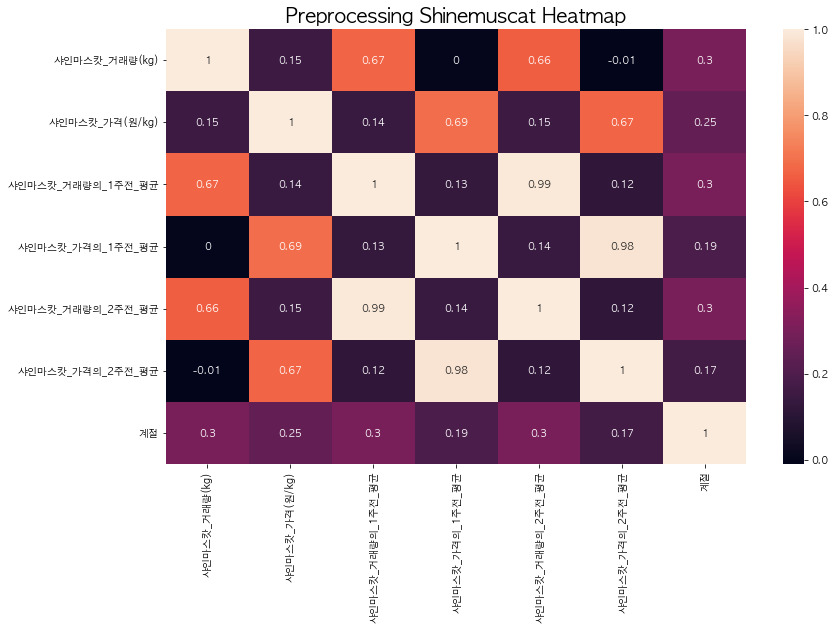

In [199]:
preprocessing_shine_corr = preprocessing_shine.copy()
preprocessing_shine_corr = preprocessing_shine_corr.corr().round(2)
ax = sns.heatmap(preprocessing_shine_corr, annot=True)
plt.title('Preprocessing Shinemuscat Heatmap', fontsize=20)
plt.show()

In [200]:
preprocessing_shine[preprocessing_shine['샤인마스캇_거래량의_1주전_평균'].isna()]

,date,요일,샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg),샤인마스캇_거래량의_1주전_평균,샤인마스캇_가격의_1주전_평균,샤인마스캇_거래량의_2주전_평균,샤인마스캇_가격의_2주전_평균,계절


In [201]:
import scipy.stats as stats

Y =  preprocessing_shine['샤인마스캇_가격(원/kg)'].values

for item in ['샤인마스캇_거래량(kg)', '샤인마스캇_거래량의_1주전_평균',
       '샤인마스캇_가격의_1주전_평균', '샤인마스캇_거래량의_2주전_평균', '샤인마스캇_가격의_2주전_평균', '계절']:
    print(item)
    X = preprocessing_shine[item].values
    print('Covariance:{:.2f}'.format(np.cov(X,Y)[0,1]))
    print('Correlation:{:.2f}'.format(stats.pearsonr(X,Y)[0])) 
#     print('P-value:{:.4f}'.format(stats.pearsonr(X,Y)[1]))
    print('\n')

샤인마스캇_거래량(kg)
Covariance:35837852.20
Correlation:0.15


샤인마스캇_거래량의_1주전_평균
Covariance:19508451.07
Correlation:0.14


샤인마스캇_가격의_1주전_평균
Covariance:43648664.07
Correlation:0.69


샤인마스캇_거래량의_2주전_평균
Covariance:18482359.99
Correlation:0.15


샤인마스캇_가격의_2주전_평균
Covariance:42263359.16
Correlation:0.67


계절
Covariance:2162.23
Correlation:0.25




## 외부데이터 상관분석

### 캠벨얼리 상관관계 파악

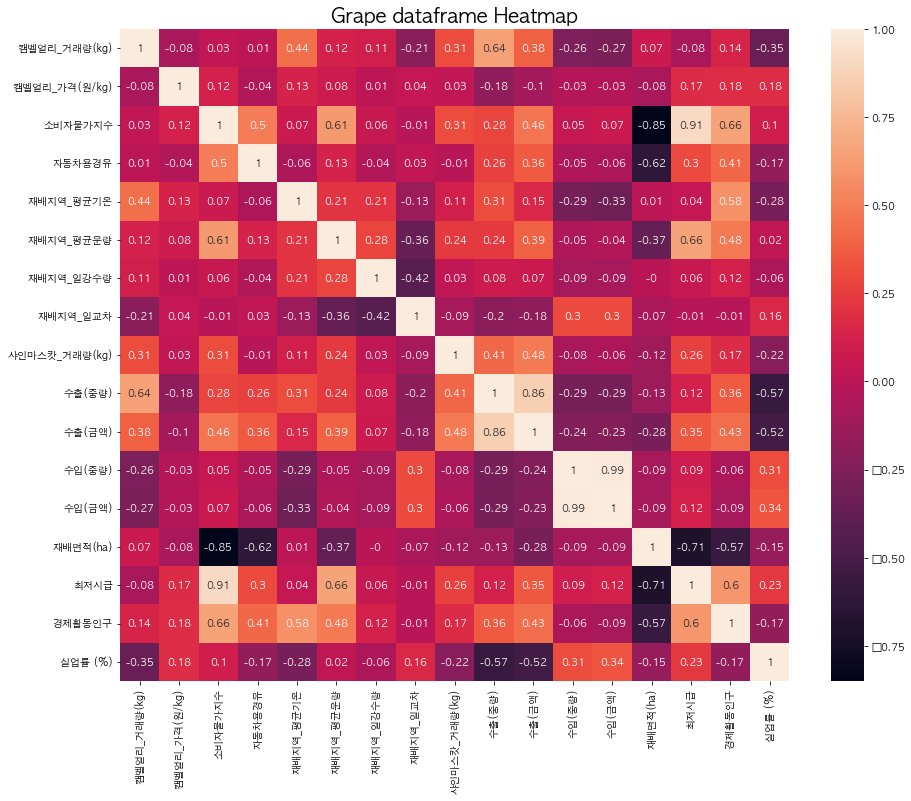

In [79]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 12)

grape_corr = grape_train.copy()
grape_corr2 = grape_corr.corr().round(2)
ax = sns.heatmap(grape_corr2, annot=True)
plt.title('Grape dataframe Heatmap', fontsize=20)
plt.show()

### 켐벨얼리 상관계수, p-value 검정

In [80]:
import scipy.stats as stats

Y =  grape_train['캠벨얼리_가격(원/kg)'].values

for item in ['캠벨얼리_거래량(kg)', '소비자물가지수', '자동차용경유', '재배지역_평균기온',
       '재배지역_평균운량', '재배지역_일강수량', '재배지역_일교차', '샤인마스캇_거래량(kg)', '수출(중량)',
       '수출(금액)', '수입(중량)', '수입(금액)', '재배면적(ha)', '최저시급', '경제활동인구', '실업률 (%)']:
    print(item)
    X = grape_train[item].values
    print('Covariance:{:.2f}'.format(np.cov(X,Y)[0,1]))
    print('Correlation:{:.2f}'.format(stats.pearsonr(X,Y)[0]))
    print('P-value:{:.4f}'.format(stats.pearsonr(X,Y)[1]))
    print('\n')

캠벨얼리_거래량(kg)
Covariance:-40884409.97
Correlation:-0.08
P-value:0.0013


소비자물가지수
Covariance:397.32
Correlation:0.12
P-value:0.0000


자동차용경유
Covariance:-8884.19
Correlation:-0.04
P-value:0.0863


재배지역_평균기온
Covariance:2706.95
Correlation:0.13
P-value:0.0000


재배지역_평균운량
Covariance:523.52
Correlation:0.08
P-value:0.0004


재배지역_일강수량
Covariance:295.58
Correlation:0.01
P-value:0.5919


재배지역_일교차
Covariance:348.97
Correlation:0.04
P-value:0.0723


샤인마스캇_거래량(kg)
Covariance:1395597.30
Correlation:0.03
P-value:0.2665


수출(중량)
Covariance:-1828150.32
Correlation:-0.18
P-value:0.0000


수출(금액)
Covariance:-10850216.33
Correlation:-0.10
P-value:0.0000


수입(중량)
Covariance:-11456200.11
Correlation:-0.03
P-value:0.2144


수입(금액)
Covariance:-31727445.31
Correlation:-0.03
P-value:0.2302


재배면적(ha)
Covariance:-152399.09
Correlation:-0.08
P-value:0.0005


최저시급
Covariance:372424.18
Correlation:0.17
P-value:0.0000


경제활동인구
Covariance:5475357.88
Correlation:0.18
P-value:0.0000


실업률 (%)
Covariance:6.96
Correlation:

### 샤인머스캇 상관관계 파악

In [81]:
shinemuscat_train.columns

Index(['date', '요일', '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)', '소비자물가지수', '자동차용경유',
       '재배지역_평균기온', '재배지역_평균운량', '재배지역_일강수량', '재배지역_일교차', '수출(중량)', '수출(금액)',
       '수입(중량)', '수입(금액)', '재배면적(ha)', '블루베리_거래물량(kg)', '최저시급', '경제활동인구',
       '실업률 (%)'],
      dtype='object')

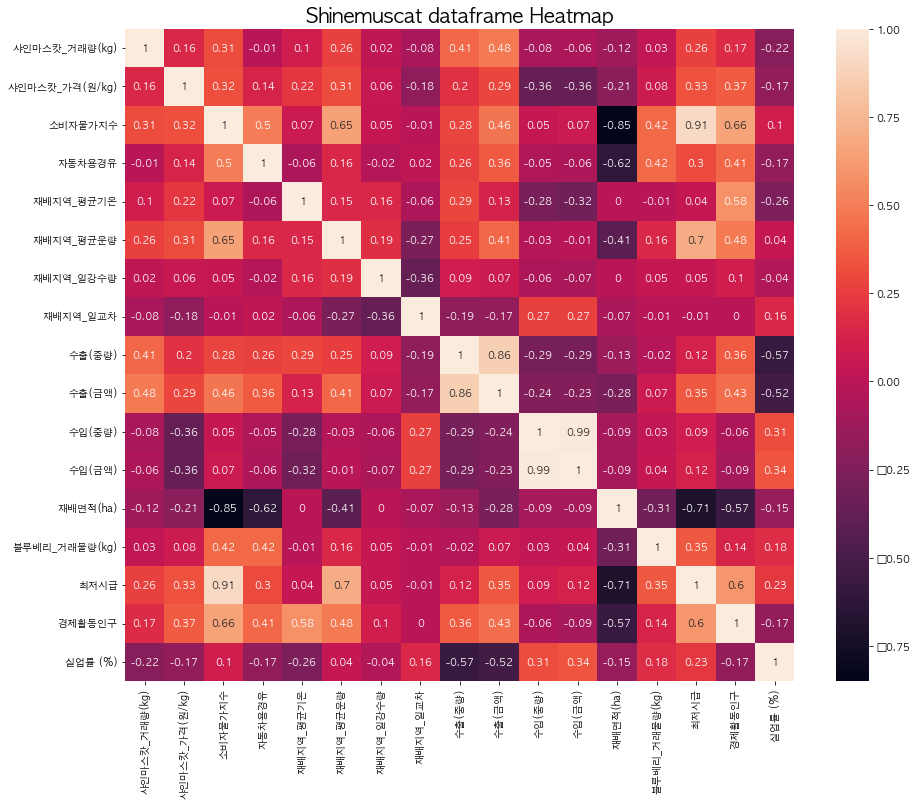

In [82]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 12)

shinemuscat_corr = shinemuscat_train.copy()
shinemuscat_corr = shinemuscat_corr.corr()
shinemuscat_corr2 = shinemuscat_corr.round(2) 
ax = sns.heatmap(shinemuscat_corr2, annot=True)
plt.title('Shinemuscat dataframe Heatmap', fontsize=20)
plt.show()

### 샤인머스켓 상관계수, p-value 검정

In [85]:
import scipy.stats as stats

Y =  shinemuscat_train['샤인마스캇_가격(원/kg)'].values

for item in ['샤인마스캇_거래량(kg)', '소비자물가지수', '자동차용경유', '재배지역_평균기온',
       '재배지역_평균운량', '재배지역_일강수량', '재배지역_일교차', '수출(중량)', '수출(금액)', '수입(중량)',
       '수입(금액)', '재배면적(ha)', '블루베리_거래물량(kg)', '최저시급', '경제활동인구', '실업률 (%)']:
    print(item)
    X = shinemuscat_train[item].values
    print('Covariance:{:.2f}'.format(np.cov(X,Y)[0,1]))
    print('Correlation:{:.2f}'.format(stats.pearsonr(X,Y)[0]))
    print('P-value:{:.4f}'.format(stats.pearsonr(X,Y)[1]))
    print('\n')

샤인마스캇_거래량(kg)
Covariance:30524707.03
Correlation:0.16
P-value:0.0000


소비자물가지수
Covariance:3932.20
Correlation:0.32
P-value:0.0000


자동차용경유
Covariance:110671.94
Correlation:0.14
P-value:0.0000


재배지역_평균기온
Covariance:16968.39
Correlation:0.22
P-value:0.0000


재배지역_평균운량
Covariance:8060.85
Correlation:0.31
P-value:0.0000


재배지역_일강수량
Covariance:5588.60
Correlation:0.06
P-value:0.0112


재배지역_일교차
Covariance:-5692.64
Correlation:-0.18
P-value:0.0000


수출(중량)
Covariance:7689515.30
Correlation:0.20
P-value:0.0000


수출(금액)
Covariance:111110125.90
Correlation:0.29
P-value:0.0000


수입(중량)
Covariance:-513531062.02
Correlation:-0.36
P-value:0.0000


수입(금액)
Covariance:-1459983567.23
Correlation:-0.36
P-value:0.0000


재배면적(ha)
Covariance:-1384545.96
Correlation:-0.21
P-value:0.0000


블루베리_거래물량(kg)
Covariance:50865.17
Correlation:0.08
P-value:0.0009


최저시급
Covariance:2631533.90
Correlation:0.33
P-value:0.0000


경제활동인구
Covariance:41383323.06
Correlation:0.37
P-value:0.0000


실업률 (%)
Covariance:-23.10
Cor